======================== 2019-05-27 ========================

              Open    High     Low   Close  Volume    Change
Date                                                        
2019-05-14  107500  108000  105000  106500   92820 -0.018433
2019-05-15  107000  107500  105000  107000   68937  0.004695
2019-05-16  107000  107500  104000  105000   64234 -0.018692
2019-05-17  105500  106500  103000  103500   58535 -0.014286
2019-05-20  104000  105000  103000  103500   29161  0.000000
2019-05-21  103500  104500  103000  104000   49726  0.004831
2019-05-22  104000  104000   99800  101000  119856 -0.028846
2019-05-23  101000  102000   99800  100000   90766 -0.009901
2019-05-24   99900  101500   99800  100500   48221  0.005000
2019-05-27  100500  101000   99700  100500   41664  0.000000 

hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 28, 20), dtype=float32)


C:\ProgramData\Anaconda3\envs\bkhan2002\lib\site-packages\ipykernel_launcher.py:176: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\ProgramData\Anaconda3\envs\bkhan2002\lib\site-packages\ipykernel_launcher.py:176: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, stateful=False, input_shape=(28, 5))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 28, 128)           68608     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 200,321
Trainable params: 200,321
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 3331 samples, validate on 1428 samples
Epoch 1/10
3331/3331 [==============================] - 7s 2ms/step - loss: 5.4659e-04 - val_loss: 0.0012
Epoch 2/10
3331/3331 [==============================] - 6s 2ms/ste

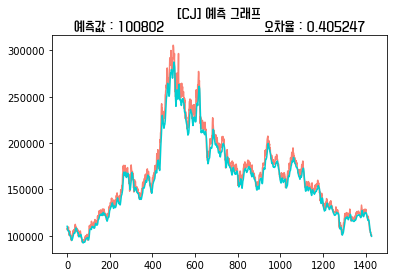

In [2]:
import tensorflow as tf
import pandas as pd
import pandas_datareader.data as web
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
import FinanceDataReader as fdr
import pymysql
import matlab
matplotlib.rcParams['axes.unicode_minus'] = False
#default_graph로 graph 초기화
tf.reset_default_graph()

connection = pymysql.connect(host='222.122.86.187', port=3306, user='geniuses777', password='stock7840',
                       db='geniuses777', charset='utf8')


#오늘 날짜
now = dt.datetime.now()
nowDate = now.strftime('%Y-%m-%d')
print("========================", nowDate, "========================\n")

tf.set_random_seed(777)

# Standardization



def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원

def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

input_data_column_cnt = 6  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율 
epoch_num = 1000          # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

## 데이터 불러오기
df = fdr.DataReader('001040', '2000-01-04', nowDate)
print(df.tail(10), "\n")
print("="*55)


### 데이터 전처리 / Data Preprocessing

stock_info = df.values[1:,:-1].astype(np.float)

price = stock_info[:,:-1]
norm_price = min_max_scaling(price)

volume = stock_info[:,-1:]
norm_volume = min_max_scaling(volume)

close = stock_info[:,-2:-1]


## 데이터셋 생성하기 / Creating Dataset

# 행은 그대로 두고 열을 우측에 붙여 합친다 / leave the row, and attach columns to right
x = np.concatenate((norm_price, norm_volume), axis=1) # axis=1
y = x[:, [-2]] # 타켓은 주식 종가이다 / target is 'Close' price

# dataX와 dataY 생성 / Creating dataset 'dataX' and 'dataY'
seq_length = 28

dataX = [] # 입력으로 사용될 Sequence Data / Input - Sequence Data
dataY = [] # 출력(타켓)으로 사용 / Output(target)
for i in range(0, int(len(y) - seq_length)):
    _x = x[i : i + seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답) / after 5 days later (in _x), 'Close' price is the correct answer.
    dataX.append(_x) # dataX 리스트에 추가 / add to dataX's list
    dataY.append(_y) # dataY 리스트에 추가 / add to dataY's list


# 학습용/테스트용 데이터 생성
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size

# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다

X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt-1])
Y = tf.placeholder(tf.float32, [None, 1])

# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])

 
predictions = tf.placeholder(tf.float32, [None, 1])


def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()
 
# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)

print("hypothesis: ", hypothesis)
# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임
 
train = optimizer.minimize(loss)
 
# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

###
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다

test_predict = ''
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})


## LSTM 모델

model = Sequential()
model.add(LSTM(128, input_dim=input_data_column_cnt-1, input_length=seq_length, return_sequences=True, stateful=False))
model.add(LSTM(128, return_sequences=False, stateful=False))
model.add(Dense(1))
model.add(Activation('linear'))
# , dropout=0.2


# 모델 학습 설정 및 진행
keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
print("="*50)
model.fit(trainX, trainY, epochs=10, batch_size=30, verbose=1, validation_data=(testX, testY))


# 학습 과정 살펴보기

recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)

recent_d = np.array([x[len(x)-seq_length -1: -1]])

test_predict = sess.run(hypothesis, feed_dict={X: recent_data})
test_p = sess.run(hypothesis, feed_dict={X: recent_d})
test_p= reverse_min_max_scaling(price,test_p)
today_stock = test_p[0]
print("Today's stock price", today_stock)

print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(price,test_predict) # 금액데이터 역정규화한다
tomorrow_stock = test_predict[0]
print("Tomorrow's stock price", tomorrow_stock)

error_factor = abs(close[-1] - test_p[-1]) / close[-1] * 100
print("error_factor: ", error_factor)

rate = (close[-1] - test_predict[-1]) / close[-1] * 100
print("rate: ", rate)

bb_f_text = 'accuracy: %f' %error_factor
# 예측
font_path = "C:/Windows/Fonts/a옛날목욕탕L.ttf"
fontprop = fm.FontProperties(fname=font_path, size=15)

y_pred = model.predict(testX, batch_size=10, verbose=1) # , steps=5
testY = reverse_min_max_scaling(price,testY) # 금액데이터 역정규화한다
y_pred = reverse_min_max_scaling(price,y_pred) # 금액데이터 역정규화한다
plt.figure(1)
plt.plot(testY, color = 'salmon')
plt.plot(y_pred, color = 'darkturquoise')
plt.title('[CJ] 예측 그래프\n예측값 : %d \t\t\t\t\t\t\t\t오차율 : %s' % (tomorrow_stock,round(error_factor[-1], 6)), fontproperties=fontprop)
fig = plt.figure(1)
plt.show()
fig.savefig("./graph/CJ.png",dpi=300)
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다

def convertToBinaryData(filename):
    with open(filename, 'rb') as file:
        binaryData = file.read()
    return binaryData

# MySQL Connection 연결

connection = pymysql.connect(host='222.122.86.187', port=3306, user='geniuses777', password='stock7840', db='geniuses777', charset='utf8')
try:
    with connection.cursor() as cursor:
        sql = 'INSERT INTO Stock_ (`company_name`, `stock_price`, `accuracy`, `rate`, `image`) VALUES (%s, %s, %s, %s, %s) ON DUPLICATE KEY UPDATE stock_price = VALUES(stock_price), image = VALUES(image)'
        image = convertToBinaryData("D:\jupyter_project\graph\\CJ.png")
        cursor.execute(sql, ('CJ', int(tomorrow_stock), float(error_factor), float(rate), image))          # 넣으려는 값
        connection.commit()
     
        sql = "select stock_price from Stock_ WHERE company_name='CJ'"
        
        cursor.execute("set names utf8")
        
        cursor.execute(sql)
        
        result_stock_price = cursor.fetchone()
        
        for i in result_stock_price:
            price = i
            
        sql = "UPDATE `Stock_` SET `accuracy` = %s WHERE `company_name` = %s"
        
        error_factor = float(abs(close[-1] - test_p[-1]) / close[-1] * 100)
        cursor.execute(sql, (error_factor, 'CJ'))
        
        connection.commit()
        
        sql = "select stock_price from Stock_ WHERE company_name='CJ'"
        
        cursor.execute("set names utf8")
        
        cursor.execute(sql)
        
        result_stock_price = cursor.fetchone()
        
        for i in result_stock_price:
            price = i
        
        sql = "UPDATE `Stock_` SET `rate` = %s WHERE `company_name` = %s"
        
        rate = float((close[-1] - test_predict[-1]) / close[-1] * 100)
        
        cursor.execute(sql, (rate, 'CJ'))
        
        connection.commit()
    
finally:
    connection.close()
